In [2]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import SVG
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils #分類問題のワンホット表現を作る(分類を0,1で表現する)
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
# -*- coding:utf-8 -*-
import tensorflow as tf

print(tf.__version__) # 1.14

1.14.0


In [3]:
##手書き文字のダウンロード
b_size = 200
n_classes = 10#教師データの種類
n_hidden = 200
n_epoch = 5#５回学習

(X_train, y_train), (X_test, y_test) = mnist.load_data()#訓練データとテストデータ読み込み

#元々訓練データとテストデータを分けている（通常は訓練データからバリデーションデータを分ける）

img_size = 28

import collections

print(X_train.shape)#60000, 28, 28(28*28の画像が60000個)
print(X_test[0][14])#8ビットデータ（グレースケール）が入っている
print(y_train.shape)#60000個
#print(y_train)
print(set(y_train))#0-9まで(教師データ)
print(collections.Counter(y_train))

(60000, 28, 28)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  59 249
 254  62   0   0   0   0   0   0   0   0]
(60000,)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [5]:
print(np.array(X_train[0]>0, dtype=np.int).reshape(28,28))#

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [4]:
X_train = X_train.reshape(X_train.shape[0], img_size**2).astype('float32')/255#28*28を一列にする（2次元）、float32にした上で/255
X_test = X_test.reshape(X_test.shape[0], img_size**2).astype('float32')/255
#GPUで処理をするときは32bitでやると早い（ディープラーニングから分かる）

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

#np_utils.to_categoricalでyのラベルをベクトルに変換（3→[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]）
#https://hatakazu.hatenablog.com/entry/2017/06/08/045953

Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

#print(Y_train)
print(Y_train.shape)#60000*10に

60000 train samples
10000 test samples
(60000, 10)


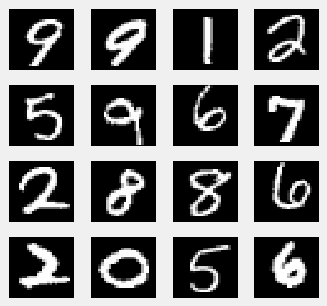

In [7]:
##手書き文字の一部が表示
def draw_digit3(data, n, numbers_size, title=None):
    plt.subplot(numbers_size, numbers_size, n)
    Z = data.reshape(img_size, img_size)
    Z = Z[::-1,:]
    plt.xlim(0, img_size-1)
    plt.ylim(0, img_size-1)
    plt.pcolor(Z)
    if title is not None:
        plt.title(title, size=9)
    plt.gray()
    plt.tick_params(labelbottom=False)
    plt.tick_params(labelleft=False)
plt.style.use('fivethirtyeight')#カラー画像の表示の時に使う
numbers_size = 4#4*4の画像を表示
plt.figure(figsize=(5,5))
for cnt,idx in enumerate(np.random.permutation(len(X_train))[:numbers_size**2]):
    draw_digit3(X_train[idx], cnt+1, numbers_size)
plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               157000    
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2010      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
________________________________________________

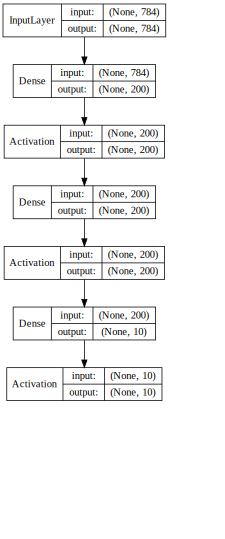

In [5]:
model = Sequential()#構造ニューラルネットを初期化

model.add(Dense(n_hidden, input_dim=img_size*img_size))#中間層１つ、結合荷重を入れる（中間層、784行列を入力に使いますよ）
model.add(Activation('relu'))#reLU関数
#Denseは入力 ,Activationは活性化関数

model.add(Dense(n_hidden))#中間層１つ、結合荷重を入れる（中間層、784行列を入力に使いますよ）
model.add(Activation('relu'))

model.add(Dense(n_classes))#10クラス分類の出力、サイズはkerasが把握しているので入力不要
model.add(Activation('softmax'))#分類はsoftmaxが定石（２値分類はsigmide）

model.summary()#モデルのサマリが出てくる

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))#モデルの出力

#(None) はミニバッチのサイズ（この例ではb_size。行列×行列にもできる）
#パラメータ数=ウェイト①の数(入力層のユニット数×中間層のユニット数)＋中間層の誤差＋ウェイト②の数（中間層のユニット数×出力層のユニット数）＋出力層の誤差

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])#学習, adam
model.fit(X_train, Y_train, batch_size=b_size, epochs=n_epoch, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5


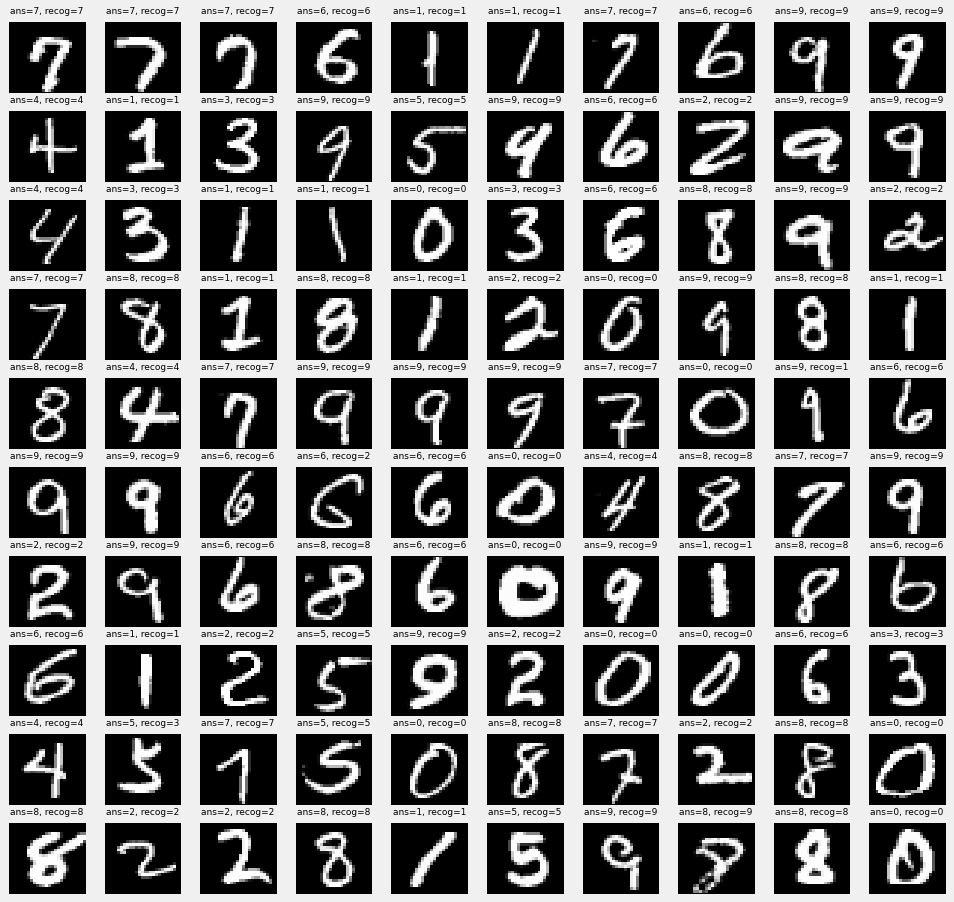

In [10]:
numbers_size = 10#10分類のうちどの分類の得点が高かったで判断
plt.figure(figsize=(15,15))
for cnt,idx in enumerate(np.random.permutation(len(X_test))[:numbers_size**2]):
    y = model.predict(X_test[int(idx):int(idx)+1], batch_size=1, verbose=0)
    draw_digit3(X_test[idx], cnt+1, numbers_size, "ans=%d, recog=%d"%(y_test[idx], np.argmax(y.data)))

In [11]:
print(score)#

[0.08110130320647732, 0.9760000109672546]


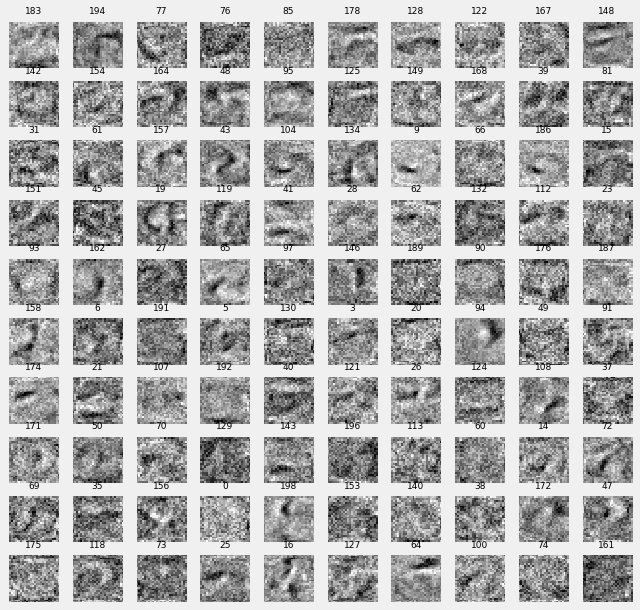

In [12]:
#中間層のユニットがどのような結合荷重を持っているか黒い線はマイナス、白はプラス。全体の明るさを反映しているものも
plt.figure(figsize=(10,10))
for cnt,i in enumerate(np.random.permutation(n_hidden)[:numbers_size**2]):
    draw_digit3(model.layers[0].get_weights()[0].T[i], cnt+1, numbers_size, "%d"%i)
plt.show()